<a href="https://colab.research.google.com/github/KevinrealG/Series_de_tiempo/blob/main/03_SeriesdeTiempo_Topologicas_Finanzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Topologico de Series de Tiempo

## DATOS y Libreria

In [1]:
#Importar Librerias
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

In [2]:
#Definir rangos de fechas
start = '2022-01-01'
end = '2023-11-30'

In [3]:
tickets = ['SPOT','NFLX']
#['AAPL', 'MSFT', 'IBM', 'INTC', 'NVDA', 'GOOG', 'TSLA', 'PYPL', 'ORCL', 'AMZN', 'NFLX', 'QCOM', 'CSCO', 'SYMC']

https://finance.yahoo.com/quote/%5EIXIC?p=^IXIC&.tsrc=fin-srch

In [4]:
prices = yf.download(tickets, start=start, end=end)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [8]:
prices.head()

,NFLX,SPOT
Date,,
2022-01-03,597.369995,244.160004
2022-01-04,591.150024,239.259995
2022-01-05,567.520020,227.699997
2022-01-06,553.289978,228.270004
2022-01-07,541.059998,223.580002


In [ ]:
# prompt: plot NFLX with green and SPOT with red
plt.figure(figsize=(15,4))

plt.plot(prices['NFLX'], color='red')
plt.plot(prices['SPOT'], color='green')
plt.title('NFLX y SPOT')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(15,4))
prices["NFLX"].plot(label="NFLX",lw=1,linestyle="-", color = 'red')
prices["SPOT"].plot(label="SPOT",lw=1,linestyle="-",color = 'green')
plt.legend()
plt.title('NETFLX y SPOTIFY')
plt.xlabel('Fecha')
plt.ylabel('Precio')

In [5]:
if isinstance(prices, pd.Series):
    prices = prices.to_frame()

In [ ]:
#Calcular rendimientos logaritmicos
log_rtn =np.log(prices/prices.shift(1))
#Eliminando NaN generados en primera linea por calculo de Log_rtn
log_rtn = log_rtn.dropna()
log_rtn

In [ ]:
plt.figure(figsize=(15,4))
log_rtn["NFLX"].plot(label="NFLX",lw=1,linestyle="-", color = 'red')
log_rtn["SPOT"].plot(label="SPOT",lw=1,linestyle="-",color = 'green')
plt.legend()
plt.title('NETFLX y SPOTIFY')
plt.xlabel('Fecha')
plt.ylabel('Precio')

In [20]:
!pip3 install visibility-graph --break-system-packages

In [26]:
#Identificar datos faltantes
print("Hay {} datos".format(len(log_rtn)))

for i in log_rtn.columns:
    missing_data_count = len(log_rtn[log_rtn[i].isna()])
    missing_data_percentage = np.round(missing_data_count / len(log_rtn) * 100, 2)

    print("Hay {} ({}%) datos faltantes en la columna {}".format(
        missing_data_count, missing_data_percentage, i
    ))

Hay 479 datos
Hay 0 (0.0%) datos faltantes en la columna NFLX
Hay 0 (0.0%) datos faltantes en la columna SPOT


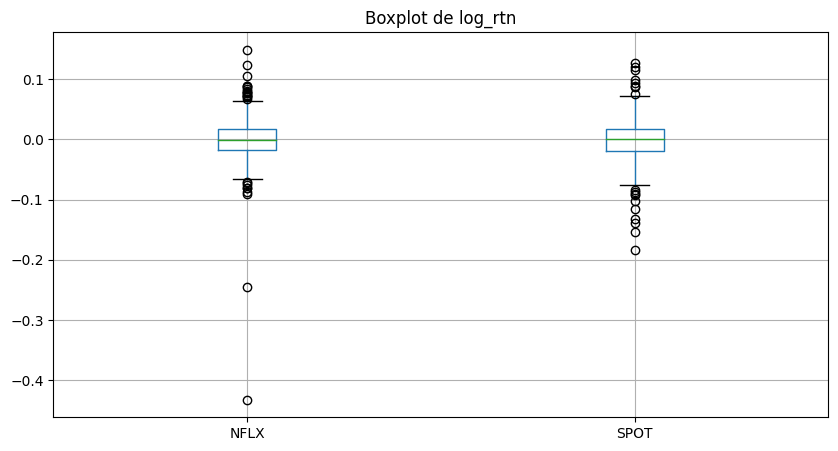

In [27]:
#Identificacion de outliers
plt.figure(figsize=(10, 5))
log_rtn.boxplot(grid=True, fontsize=10)
plt.title('Boxplot de log_rtn', fontsize=12)
plt.show()

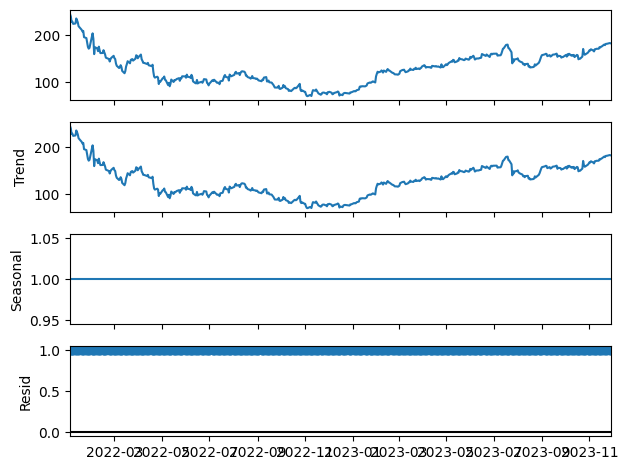

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
result1 = seasonal_decompose(pd.DataFrame(prices['SPOT']), model='mul', period=1)
result1.plot()
plt.savefig("descomposicion1.pdf",dpi=250,bbox_inches="tight")
plt.show()

## Grafos

In [21]:

from visibility_graph import visibility_graph
import networkx as nx
import sys
import statsmodels.api as sm

In [23]:
c11 = visibility_graph(log_rtn["NFLX"])
nx.write_edgelist(c11, "Netflix")
c21 = visibility_graph(log_rtn["SPOT"])
nx.write_edgelist(c21, "Spotify")

In [24]:
def removeceros(lista1, lista2):
    while 0 in lista1:
        lista2.pop(lista1.index(0))
        lista1.remove(0)
    return lista1, lista2

In [25]:
def get_alpha(data,li_fit,ls_fit,xlimi,xlims,color,name):
    G = nx.read_edgelist(data, nodetype=int)
    # Calculate degree distribution
    degree_sequence = G.degree()#[G.degree(node) for node in G.nodes()]
    degree_count = nx.degree_histogram(G)

    degrees = list(range(len(degree_count)))
    degree_count, degrees =removeceros(degree_count,degrees)

    # Normalize the degree distribution
    degree_distribution = [count / float(sum(degree_count)) for count in degree_count]
    # Calcule alpha
    x0,y0=np.array(np.log10(degrees)),np.array(np.log10(degree_distribution))
    x0,y0=x0[np.isfinite(x0)],y0[np.isfinite(x0)]
    x,y=x0[(x0>=li_fit)&(x0<=ls_fit)],y0[(x0>=li_fit)&(x0<=ls_fit)]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x)
    print_model = model.summary()

    # Plot degree distribution
    plt.figure(figsize=(6,4))
    plt.plot(x0,y0,color=color,linewidth=0,marker="P",markersize=5,label="data")
    a=np.linspace(li_fit,ls_fit,10)
    plt.plot(a,(a)*(model.params[1])+model.params[0]*1.,color="k",lw=3,label=r"fit ($\alpha_0={}$)".format(-np.round(model.params[1],2)))
    plt.xlabel(r'$\log_{10}(k)$ (Degree)'); plt.ylabel(r'$\log_{10} P(k)$'); plt.title('Degree Distribution {}'.format(name)); plt.legend(); plt.xlim(xlimi,xlims)
    plt.legend(title=r"$P(k)\sim x^{-\alpha_0}$"); plt.grid(alpha=0.5)
    #plt.savefig(data+".pdf",dpi=400,bbox_inches='tight')
    plt.show()
    return x0,y0,x,y,li_fit,ls_fit,xlimi,xlims,np.round(model.params[0],2),np.round(model.params[1],2), G

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


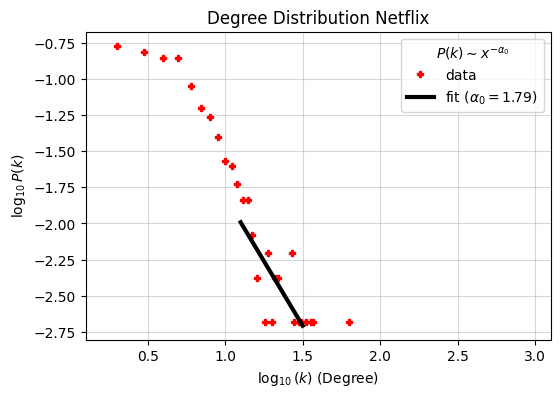

In [33]:
c11_a=get_alpha("Netflix",1.1,1.5,0.1,3.1,"red","Netflix")


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


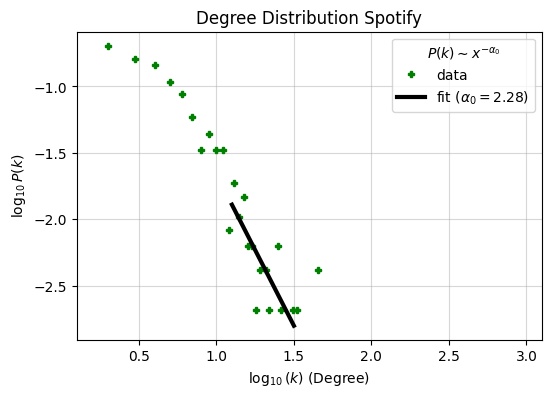

In [34]:
c21_a=get_alpha("Spotify",1.1,1.5,0.1,3.1,"green","Spotify")


In [35]:
from scipy.stats import entropy

def calculate_metrics1(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    betweenness_centrality = np.mean(list(nx.betweenness_centrality(G).values()))
    return betweenness_centrality

def calculate_metrics2(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))
    return closeness_centrality

def calculate_metrics3(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    eigenvector_centrality = np.mean(list(nx.eigenvector_centrality(G).values()))
    return eigenvector_centrality

def calculate_metrics4(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    clustering_coefficient = np.mean(list(nx.clustering(G).values()))
    return clustering_coefficient

def calculate_metrics5(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    assortativity_coefficient = nx.degree_assortativity_coefficient(G)
    return assortativity_coefficient

def higuchi_fd(data, k_max):
    n = len(data)
    L = np.arange(1, k_max + 1)
    x = np.empty((k_max,))
    y = np.empty((k_max,))
    for k in L:
        Lk = np.zeros((k,))
        for m in range(k):
            N = int(np.floor((n - m - 1) / k))
            for i in range(1, N):
                Lk[k - 1] += abs(data[m + i * k] - data[m + i * k - k])
            Lk[k - 1] = Lk[k - 1] * (n - 1) / (k * N)
        x[k - 1] = np.log(1.0 / k)
        y[k - 1] = np.log(np.mean(Lk))

    # Fit a linear regression line to (x, y) and get the slope (HFD)
    slope, _ = np.polyfit(x, y, 1)

    return slope

In [37]:
print("betweenness_centrality:",calculate_metrics1("Netflix"))
print("closeness_centrality:",calculate_metrics2("Netflix"))
print("clustering:",calculate_metrics4("Netflix"))
print("degree_assortativity_coefficient:",calculate_metrics5("Netflix"))
print("entropy:",entropy((log_rtn["NFLX"].values-log_rtn["NFLX"].values.min())/(log_rtn["NFLX"].values.max()-log_rtn["NFLX"].values.min()),base=10))
print("higuchi_fd:",higuchi_fd(log_rtn["NFLX"],10))

betweenness_centrality: 0.00638618142799854
closeness_centrality: 0.2523003272424405
clustering: 0.7597425012873325
degree_assortativity_coefficient: 0.03865555923909738
entropy: 2.678181904625528
higuchi_fd: 0.9509266192102985


In [39]:
# prompt: Calculate betweenness_centrality, closeness_centrality, clustering, degree_assortativity_coefficient, entropy, higuchi_fd for Netflix and spotify and save into a pandas dataframe table


df = pd.DataFrame(
    {
        "betweenness_centrality": [calculate_metrics1("Netflix"), calculate_metrics1("Spotify")],
        "closeness_centrality": [calculate_metrics2("Netflix"), calculate_metrics2("Spotify")],
        "clustering": [calculate_metrics4("Netflix"), calculate_metrics4("Spotify")],
        "degree_assortativity_coefficient": [calculate_metrics5("Netflix"), calculate_metrics5("Spotify")],
        "entropy": [entropy((log_rtn["NFLX"].values-log_rtn["NFLX"].values.min())/(log_rtn["NFLX"].values.max()-log_rtn["NFLX"].values.min()),base=10), entropy((log_rtn["SPOT"].values-log_rtn["SPOT"].values.min())/(log_rtn["SPOT"].values.max()-log_rtn["SPOT"].values.min()),base=10)],
        "higuchi_fd": [higuchi_fd(log_rtn["NFLX"],10), higuchi_fd(log_rtn["SPOT"],10)],
    },
    index=["Netflix", "Spotify"],
)
df


,betweenness_centrality,closeness_centrality,clustering,degree_assortativity_coefficient,entropy,higuchi_fd
Netflix,0.006386,0.252300,0.759743,0.038656,2.678182,0.950927
Spotify,0.006862,0.238516,0.753691,0.080850,2.671467,0.963217


In [40]:
df.T

,Netflix,Spotify
betweenness_centrality,0.006386,0.006862
closeness_centrality,0.252300,0.238516
clustering,0.759743,0.753691
degree_assortativity_coefficient,0.038656,0.080850
entropy,2.678182,2.671467
higuchi_fd,0.950927,0.963217


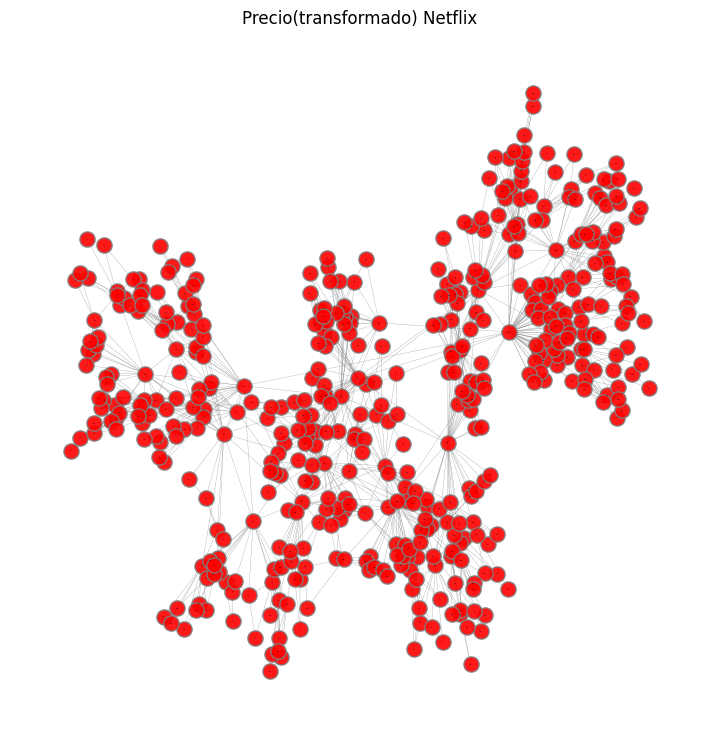

In [41]:
plt.figure(figsize=(7,7))
options = {"edgecolors": "tab:gray", "alpha": 0.9}
nodes=nx.draw(c11_a[-1],
              pos=nx.spring_layout(c11_a[-1], seed = 120),
              with_labels=True, node_color='red', edge_color='gray',
              width=0.2, node_size=120, font_size=0, **options)
plt.title("Precio(transformado) Netflix")
plt.savefig("Netflix.pdf",dpi=400,bbox_inches='tight')
plt.show()

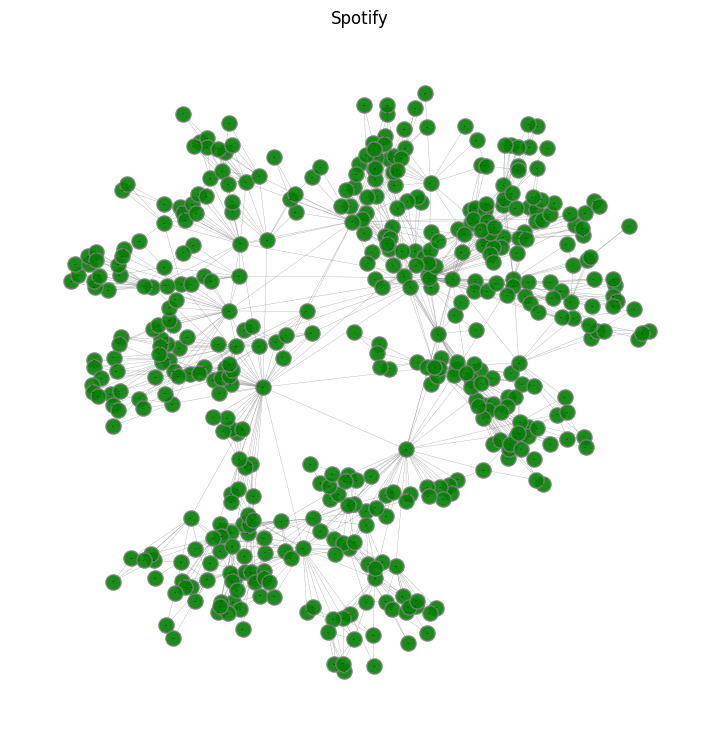

In [43]:
plt.figure(figsize=(7,7))
options = {"edgecolors": "tab:gray", "alpha": 0.9}
nodes=nx.draw(c21_a[-1],
              pos=nx.spring_layout(c21_a[-1], seed = 23),
              with_labels=True, node_color='green', edge_color='gray',
              width=0.2, node_size=120, font_size=0, **options)
plt.title("Spotify")
plt.savefig("Spotify.pdf",dpi=400,bbox_inches='tight')
plt.show()